In [1]:
import os
import tempfile
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi
import seaborn as sns
import torch
import pertpy as pt

import muon as mu

from _quasiSCVI import QuasiSCVI
from _quasivae import QuasiVAE


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.3


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Here we use the pancreas dataset described in the [scIB](https://github.com/theislab/scib) manuscript, that is also widely used to benchmark integration methods.

In [4]:
mdata = pt.dt.papalexi_2021()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name beca

In [5]:
mdata["rna"].layers['counts'] = mdata["rna"].X

In [6]:
mdata["rna"]


AnnData object with n_obs × n_vars = 20729 × 18649
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'
    layers: 'counts'

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


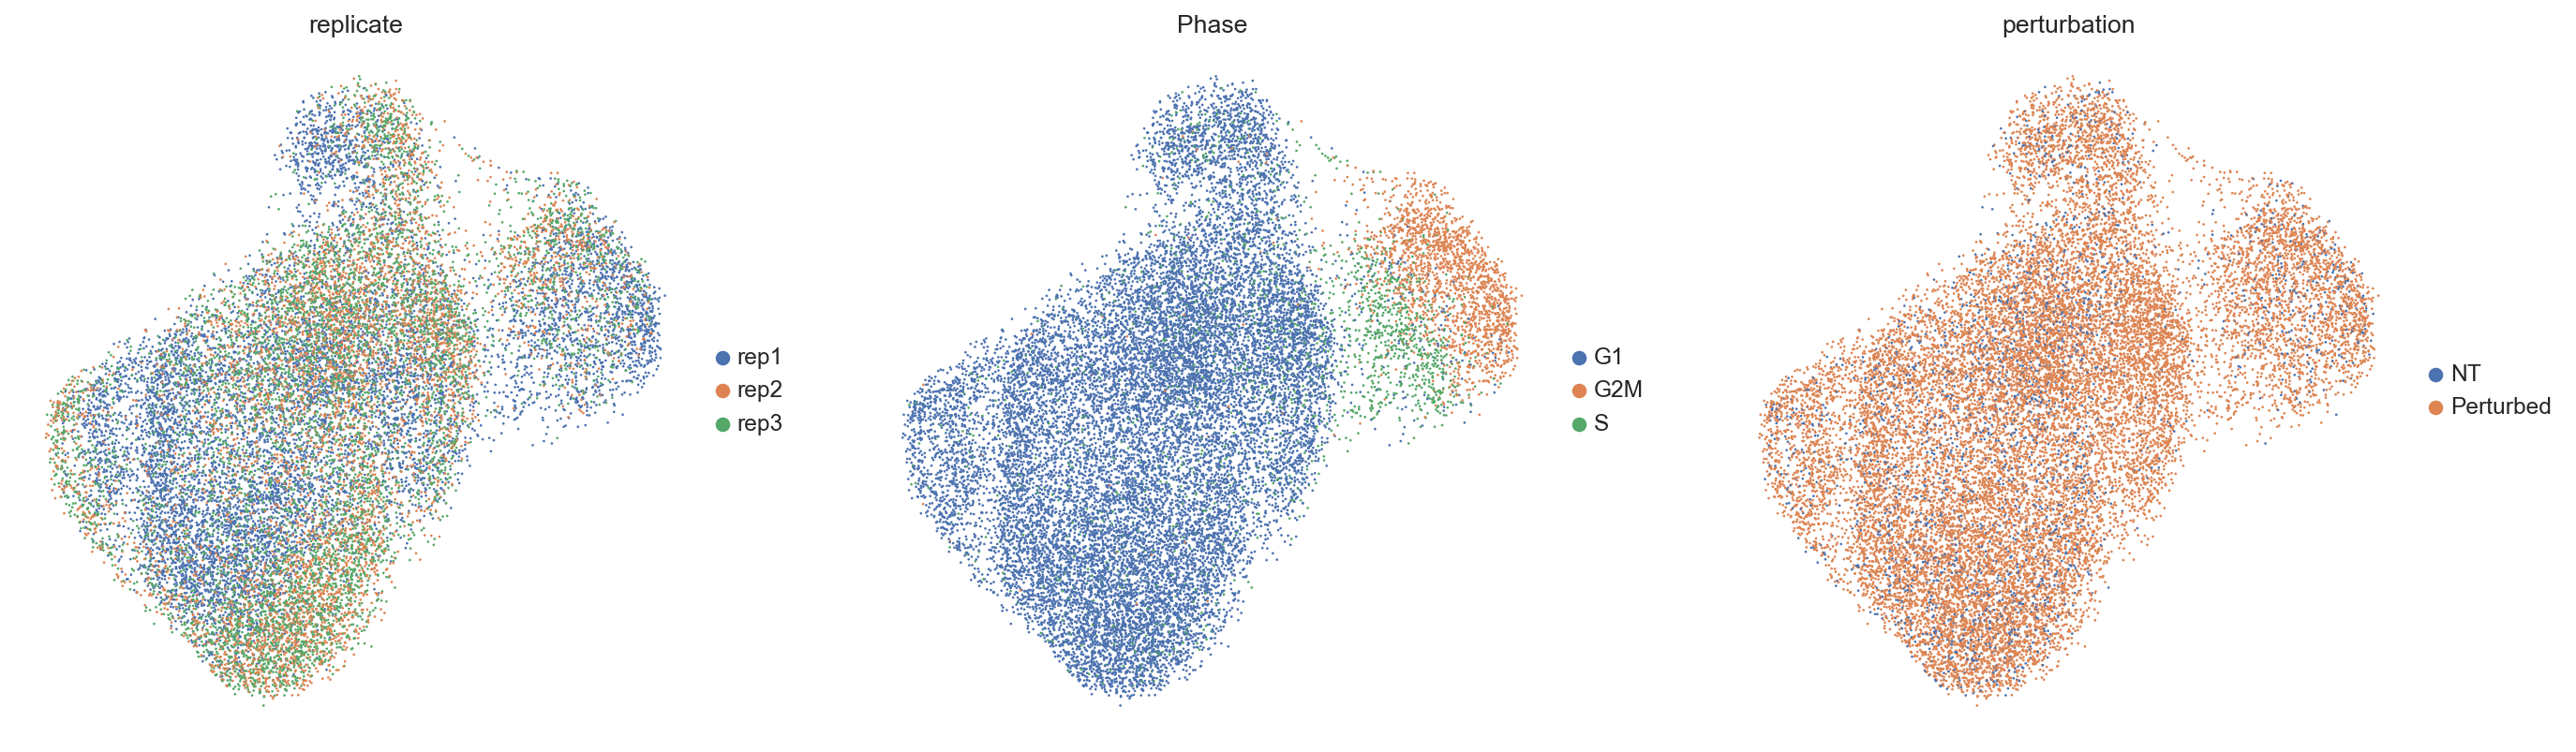

In [7]:
mdata["rna"]

sc.pp.normalize_total(mdata["rna"])
sc.pp.log1p(mdata["rna"])
sc.pp.highly_variable_genes(mdata["rna"],n_top_genes=2000, batch_key="replicate",  subset=True)
ms = pt.tl.Mixscape()
ms.perturbation_signature(mdata["rna"], "perturbation", "NT", "replicate")
adata_pert = mdata["rna"].copy()
adata_pert.X = adata_pert.layers["X_pert"]
sc.pp.pca(mdata["rna"])
sc.pp.neighbors(mdata["rna"], metric="cosine")
sc.tl.umap(mdata["rna"])
sc.pl.umap(mdata["rna"], color=["replicate", "Phase", "perturbation"])

In [8]:
ms.mixscape(adata=mdata["rna"], control="NT", labels="gene_target", layer="X_pert")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes

In [9]:
mdata_ref = mdata["rna"].copy()

In [10]:
#### Quasi Likelihood Model

In [11]:
QuasiSCVI.setup_anndata(mdata_ref, batch_key="replicate" , layer="counts")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [12]:
# Initialize the Quasi SCVI model
scvi_ref = QuasiSCVI(
    mdata_ref,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

# Train the model
scvi_ref.train(max_epochs=100, plan_kwargs={"lr": 1e-4})

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|███████████████████████████████████████████| 100/100 [05:59<00:00,  3.13s/it, v_num=1, train_loss_step=339, train_loss_epoch=340]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████████████████████████████████████████| 100/100 [05:59<00:00,  3.59s/it, v_num=1, train_loss_step=339, train_loss_epoch=340]


In [13]:
scvi_ref.history["elbo_train"]
train_loss = scvi_ref.history["elbo_train"]
kl_divergence = scvi_ref.history["kl_local_train"]

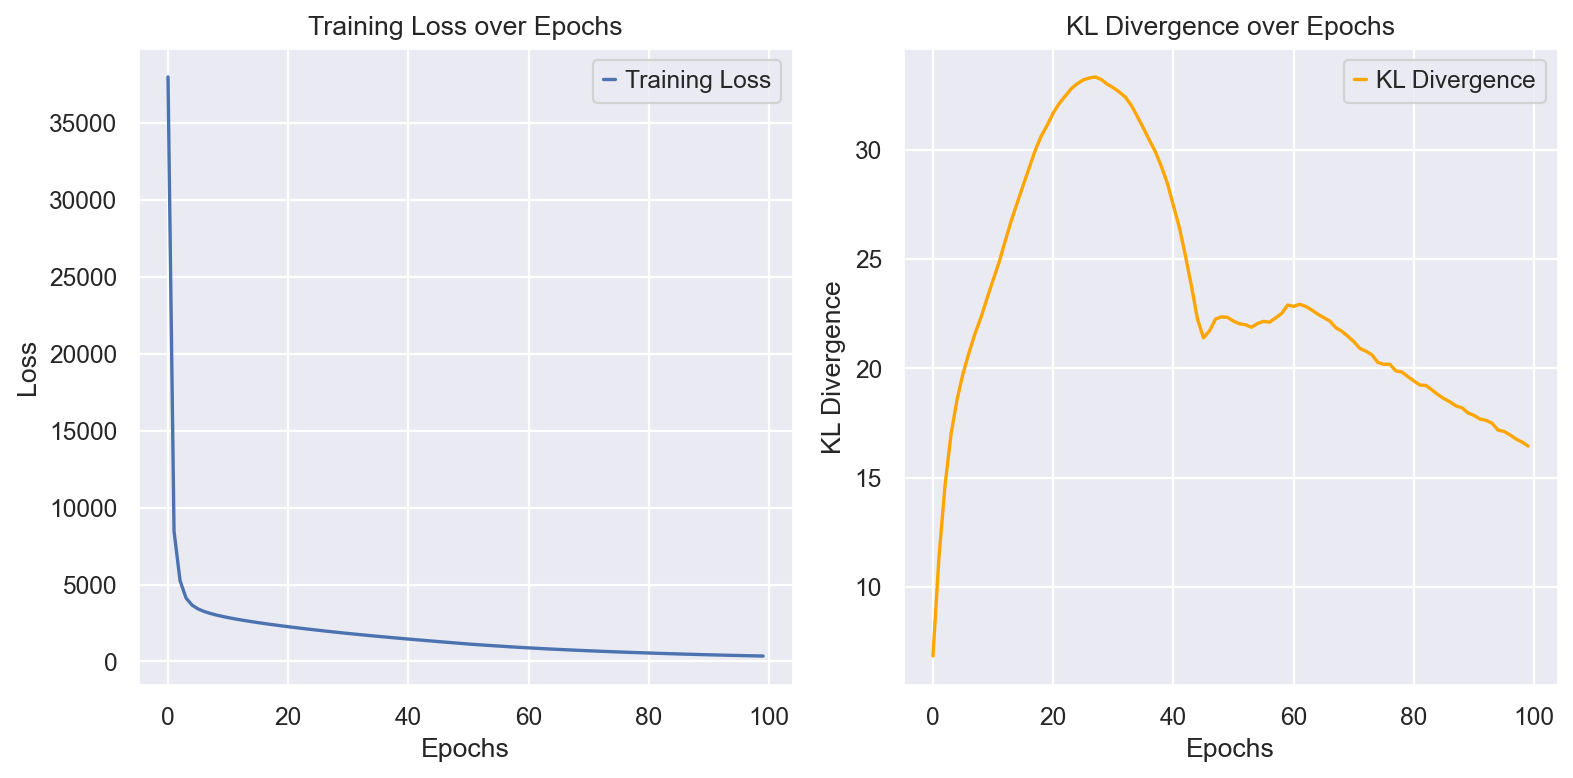

In [14]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot KL divergence
plt.subplot(1, 2, 2)
plt.plot(kl_divergence, label='KL Divergence', color='orange')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Now we obtain the latent representation, and use Scanpy to visualize with UMAP.

In [15]:
SCVI_LATENT_KEY = "X_scVI"

mdata_ref.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
sc.pp.neighbors(mdata_ref, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(mdata_ref)
sc.tl.umap(mdata_ref)

/var/folders/3k/yfw07yqn6nbdwjkxhf022b2m0000gn/T/ipykernel_68123/1824613379.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(mdata_ref)


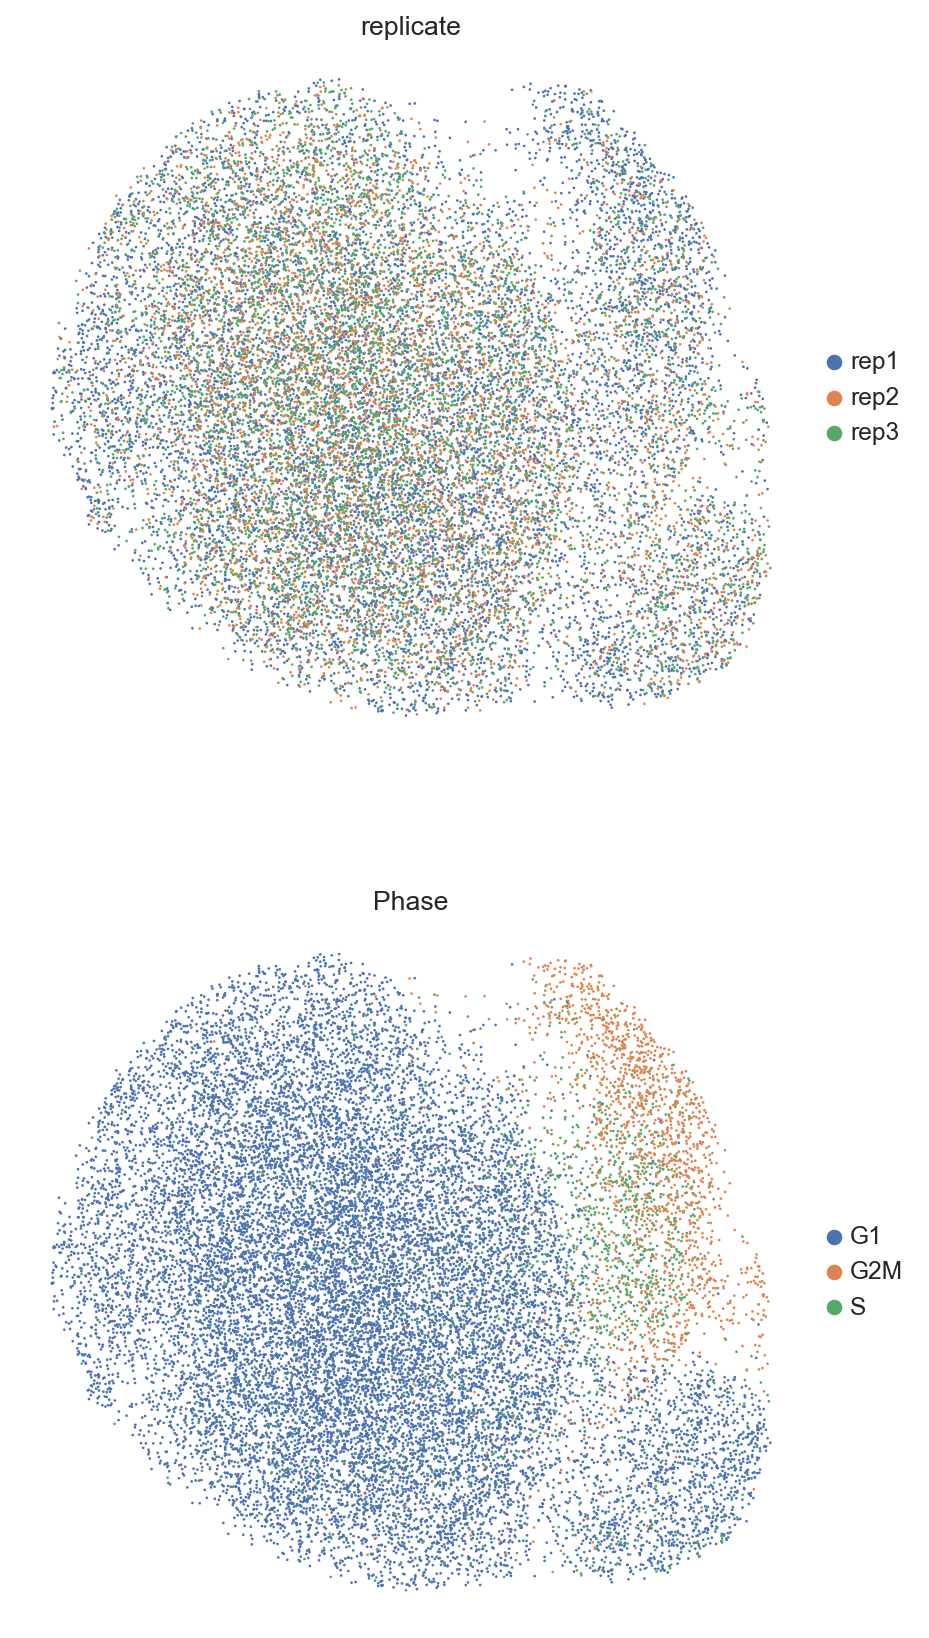

In [16]:
sc.pl.umap(
    mdata_ref,
    color=["replicate","Phase"],
    frameon=False,
    ncols=1,
)

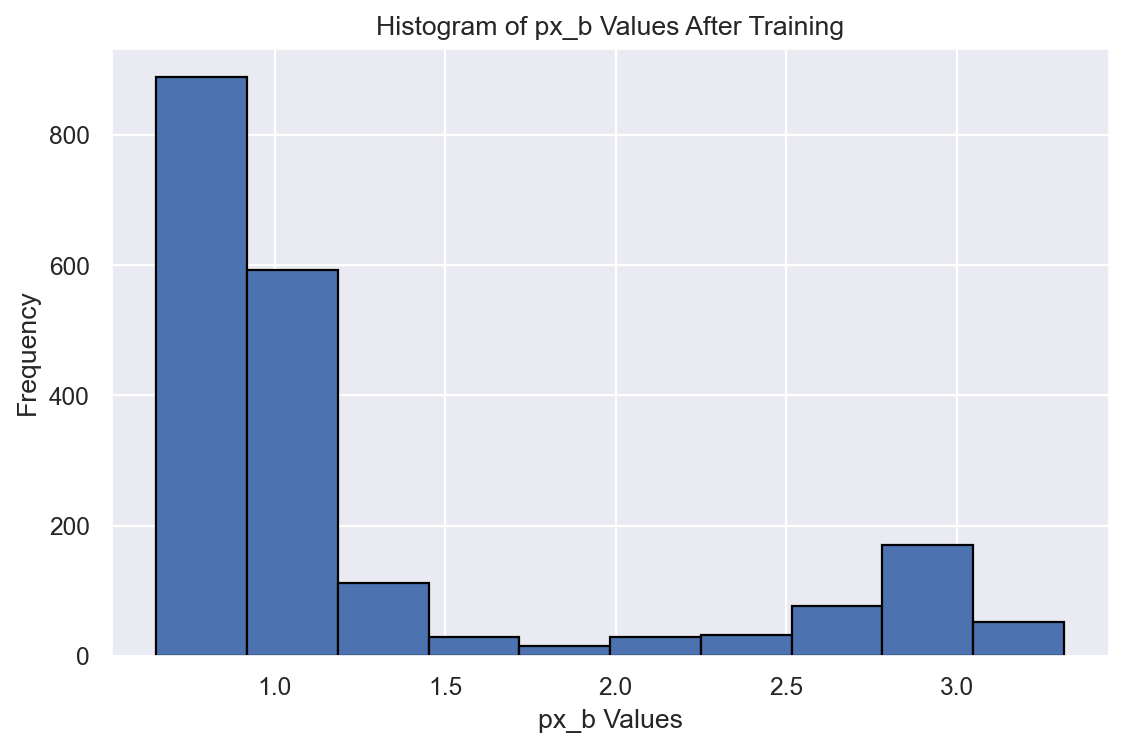

In [17]:
px_b_values = scvi_ref.module.px_b.cpu().detach().numpy()

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(px_b_values, bins=10, edgecolor='black')
plt.xlabel('px_b Values')
plt.ylabel('Frequency')
plt.title('Histogram of px_b Values After Training')
plt.grid(True)
plt.show()

In [18]:
px_b = scvi_ref.module.px_b.cpu().detach().numpy()
px_r = scvi_ref.module.px_r.cpu().detach().numpy()

In [19]:
mdata_ref

AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'mixscape_class_p_ko', 'mixscape_class', 'mixscape_class_global', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'replicate_colors', 'Phase_colors', 'perturbation_colors', 'mixscape', '_scvi_uuid', '_scvi_manager_uuid', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'X_pert'
    obsp: 'distances', 'connectivities'

In [20]:
mdata_ref = scvi_ref._validate_anndata(mdata_ref)

In [21]:
from anndata import AnnData
from scvi import REGISTRY_KEYS
from scvi.module._constants import MODULE_KEYS
@torch.inference_mode()
def get_parameters(model, adata: AnnData, batch_size: int = None):
    """Get parameters from the model's decoder after training."""

    # Prepare data loader
    scdl = model._make_data_loader(adata=adata, batch_size=batch_size, shuffle=False)

    all_px_scale = []
    all_px_rate = []
    all_library = []

    for tensors in scdl:
        # Get inference input
        inference_input = {
            MODULE_KEYS.X_KEY: tensors[REGISTRY_KEYS.X_KEY],
            MODULE_KEYS.BATCH_INDEX_KEY: tensors[REGISTRY_KEYS.BATCH_KEY],
            MODULE_KEYS.CONT_COVS_KEY: tensors.get(REGISTRY_KEYS.CONT_COVS_KEY, None),
            MODULE_KEYS.CAT_COVS_KEY: tensors.get(REGISTRY_KEYS.CAT_COVS_KEY, None),
        }

        # Run regular inference
        inference_outputs = model.module._regular_inference(
            x=inference_input[MODULE_KEYS.X_KEY],
            batch_index=inference_input[MODULE_KEYS.BATCH_INDEX_KEY],
            cont_covs=inference_input.get(MODULE_KEYS.CONT_COVS_KEY),
            cat_covs=inference_input.get(MODULE_KEYS.CAT_COVS_KEY),
        )
        generative_input= scvi_ref.module._get_generative_input(tensors,inference_outputs)
        generative_output=scvi_ref.module.generative(
            z=generative_input[MODULE_KEYS.Z_KEY],
            library=generative_input[MODULE_KEYS.LIBRARY_KEY],
            batch_index=generative_input[MODULE_KEYS.BATCH_INDEX_KEY],
            cont_covs=generative_input.get(MODULE_KEYS.CONT_COVS_KEY),
            cat_covs=generative_input.get(MODULE_KEYS.CAT_COVS_KEY),
            size_factor=generative_input.get(MODULE_KEYS.SIZE_FACTOR_KEY),
            y=generative_input.get(MODULE_KEYS.Y_KEY))
        
         # Collect the outputs
        all_library.append(generative_input[MODULE_KEYS.LIBRARY_KEY].cpu().numpy())
        all_px_scale.append(generative_output["px_scale"].cpu().numpy())
        all_px_rate.append(generative_output["px_rate"].cpu().numpy())
        

    all_px_scale = np.concatenate(all_px_scale, axis=0)
    all_px_rate = np.concatenate(all_px_rate, axis=0)
    all_library = np.concatenate(all_library, axis=0)

    #before it was  (20729, 2000)
    #To lower dimesions and  get shape (2000,) to match operations afterwards
    px_rate_mean = np.mean(all_px_rate, axis=0)



    return all_px_scale,px_rate_mean, all_library

# Use the function to get the parameters
px_scale, px_rate , library= get_parameters(scvi_ref, mdata_ref)

# You can now plot or analyze px_scale, px_r, px_rate, px_dropout as needed


In [27]:
print("Shape of px_scale:", px_scale.shape)
print("Shape of rate:", px_rate.shape)
print("Shape of library:",library.shape)
print("Shape of px_r:",px_r.shape)
print("Shape of px_b:",px_b.shape)

Shape of px_scale: (20729, 2000)
Shape of rate: (2000,)
Shape of library: (20729, 1)
Shape of px_r: (2000,)
Shape of px_b: (2000,)


In [28]:
# Extract control cells
control_cells = mdata_ref[mdata_ref.obs['mixscape_class'] == 'NT'].copy()
sc.pp.subsample(control_cells, n_obs = 1000)
control_cells = control_cells.X.todense()

# # Extract NP (Non-Perturbed) cells
# np_cells = mdata["rna"][mdata["rna"].obs['mixscape_class'].str.endswith(' NP')].X.todense()

gene = 'IFNGR2'  # 'IFNGR2', 'CUL3', 'JAK2', 'MYC', 'STAT2', 'IRF1' 

# Extract single KO NP  cells
np_cells = mdata_ref[(mdata_ref.obs['gene_target'].isin([gene])) & (mdata_ref.obs['mixscape_class'].str.endswith(' NP'))].X.todense()


# Extract KO (Knockout) cells
ko_cells = mdata_ref[mdata_ref.obs['mixscape_class'].str.endswith(' KO')].X.todense()


# Extract STAT5A KO  cells
singleko_cells = mdata_ref[(mdata_ref.obs['gene_target'].isin([gene])) & (mdata_ref.obs['mixscape_class'].str.endswith(' KO'))].X.todense()

rep1_KO_cells = mdata_ref[
    (mdata_ref.obs['mixscape_class'].str.endswith(' KO')) & 
    (mdata_ref.obs['replicate'] == "rep1")
].X.todense()

# Print shapes to verify the results
print(f"Control cells shape: {control_cells.shape}")
print(f"NP cells shape: {np_cells.shape}")
print(f"KO cells shape: {ko_cells.shape}")
print(f"rep1_KO cells shape: {rep1_KO_cells.shape}")
print(f"single_KO cells shape: {singleko_cells.shape}")

Control cells shape: (1000, 2000)
NP cells shape: (306, 2000)
KO cells shape: (5238, 2000)
rep1_KO cells shape: (2498, 2000)
single_KO cells shape: (907, 2000)


In [29]:
# transforming edgeR source code for mean-var plot to python code


# Define the functions
def bin_mean_var(x, group, nbins=100, common_dispersion=False, object=None):
    x = np.asarray(x)
    group = pd.Categorical(group)
    ntags, nlibs = x.shape
    means = np.mean(x, axis=1)

    if len(np.unique(group)) > 1:
        design = pd.get_dummies(group)
        model = OLS(x.T, add_constant(design)).fit()
        vars_ = model.mse_resid
    else:
        vars_ = np.sum((x - means[:, None]) ** 2, axis=1) / (nlibs - 1)

    bins = []
    var_bins = []
    means_bins = []
    o = np.argsort(means)
    ntags_in_bin = ntags // nbins

    if common_dispersion:
        comdisp_bin = np.full(nbins, np.nan)
        dispersions = np.full(ntags, np.nan)
    else:
        dispersions = None

    for i in range(nbins):
        if i == nbins - 1:
            bin_indices = o[(i * ntags_in_bin):]
        else:
            bin_indices = o[(i * ntags_in_bin):((i + 1) * ntags_in_bin)]
        bins.append(bin_indices)
        means_bins.append(means[bin_indices])
        var_bins.append(vars_[bin_indices])

        if common_dispersion and object is not None:
            comdisp_bin[i] = estimate_common_disp(object[bin_indices, :])
            dispersions[bin_indices] = comdisp_bin[i]

    sqrt_means = [np.sqrt(mb) for mb in means_bins]
    sqrt_vars = [np.sqrt(vb) for vb in var_bins]
    ave_means = np.array([np.mean(sm) ** 2 for sm in sqrt_means])
    ave_vars = np.array([np.mean(sv) ** 2 for sv in sqrt_vars])

    if common_dispersion:
        comdisp_vars = ave_means + comdisp_bin * ave_means ** 2
    else:
        comdisp_vars = None
        comdisp_bin = None

    return {
        'avemeans': ave_means,
        'avevars': ave_vars,
        'bin_means': means_bins,
        'bin_vars': var_bins,
        'means': means,
        'vars': vars_,
        'common_dispersion_vars': comdisp_vars,
        'binned_common_dispersion': comdisp_bin,
        'dispersions': dispersions,
        'bins': bins
    }



# Compute mean-variance data
control_meanvar = bin_mean_var(control_cells, np.zeros(control_cells.shape[1]))
np_meanvar = bin_mean_var(np_cells, np.zeros(np_cells.shape[1]))
ko_meanvar = bin_mean_var(ko_cells, np.zeros(ko_cells.shape[1]))
ko_rep1_meanvar = bin_mean_var(rep1_KO_cells, np.zeros(rep1_KO_cells.shape[1]))
singleko_cells_meanvar = bin_mean_var(singleko_cells, np.zeros(singleko_cells.shape[1]))
# Plot mean-variance data
# plot_mean_var(control_meanvar, title='Control Cells')
# plot_mean_var(np_meanvar, title='NP Cells')
# plot_mean_var(ko_meanvar, title='KO Cells')
# plot_mean_var(ko_rep1_meanvar, title='KO_rep1 Cells')

In [30]:
def compute_mean_variance_for_bins(px_rate, px_r, px_b, meanvar):
    means_bins = []
    var_bins = []
    bins = []

    
    # Loop over each bin
    for bin_indices in meanvar['bins']:
        # Extract the learned parameters for the genes in the current bin
        bin_px_r = px_r[bin_indices]
        bin_px_rate = px_rate[bin_indices]
        bin_px_b = px_b[bin_indices]

        # Compute the mean
        mean = bin_px_rate

        # Compute the variance
        variance = bin_px_r * np.power(bin_px_rate, bin_px_b)

        # Store the mean and variance
        means_bins.append(mean)
        var_bins.append(variance)
        bins.append(bin_indices)

        
    sqrt_means = [np.sqrt(mb) for mb in means_bins]
    sqrt_vars = [np.sqrt(vb) for vb in var_bins]
    ave_means = np.array([np.mean(sm) ** 2 for sm in sqrt_means])
    ave_vars = np.array([np.mean(sv) ** 2 for sv in sqrt_vars])
        
    meanvar_for_bins = {
        'bin_means': means_bins,
        'bin_vars': var_bins,
        'avemeans': ave_means,
        'avevars': ave_vars,
        'common_dispersion_vars': None,
        'bins': bins

    }
    
    return meanvar_for_bins

/var/folders/3k/yfw07yqn6nbdwjkxhf022b2m0000gn/T/ipykernel_68123/3678284117.py:27: RuntimeWarning: invalid value encountered in sqrt
  sqrt_vars = [np.sqrt(vb) for vb in var_bins]


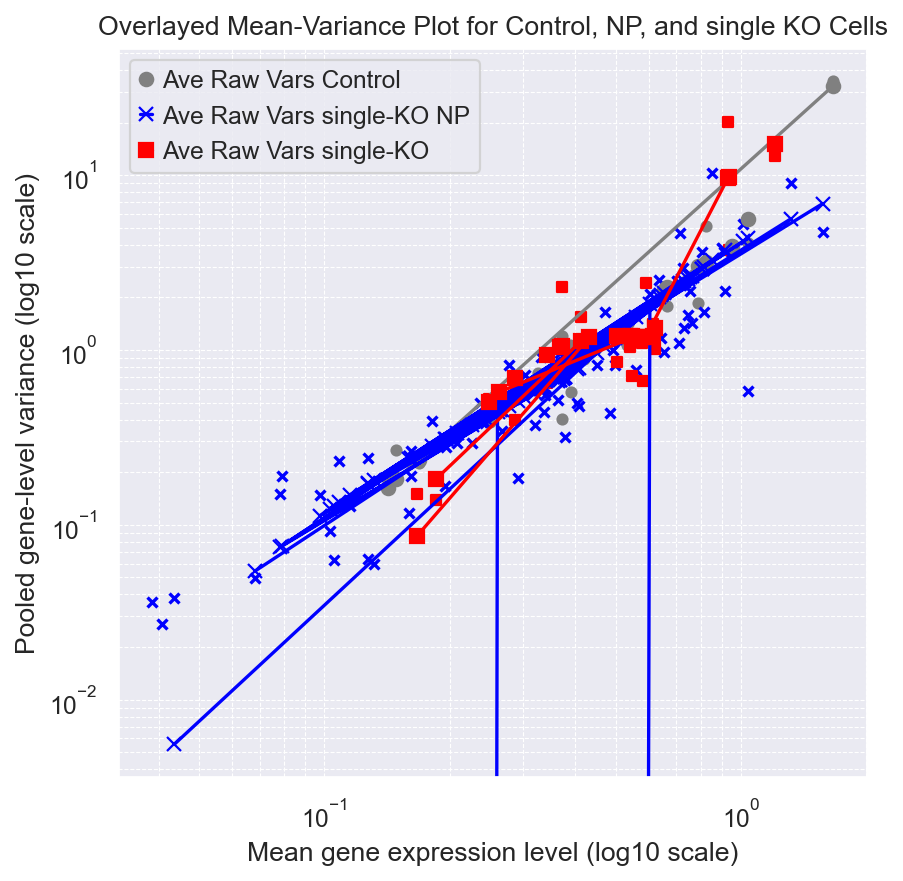

In [31]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def smoothing(x, y):
    lowess_frac = 0.8  # size of data (%) for estimation =~ smoothing window
    lowess_it = 0
    x_smooth = x
    y_smooth = lowess(y, x, is_sorted=False, frac=lowess_frac, it=lowess_it, return_sorted=False)
    return x_smooth, y_smooth


def plot_mean_var_overlay(meanvar_list,labels, title, log_axes='xy', xlab=None, ylab=None, show_raw=False, **kwargs):
    if xlab is None:
        xlab = "Mean gene expression level (log10 scale)"
    if ylab is None:
        ylab = "Pooled gene-level variance (log10 scale)"

    colors = ['gray', 'blue', 'red']
    markers = ['o', 'x', 's']

    plt.figure()
    for i, meanvar in enumerate(meanvar_list):
        avemeans =  meanvar['avemeans']
        avevars = meanvar['avevars']
        common_dispersion_vars = meanvar['common_dispersion_vars']
        xloess, yloess = smoothing(meanvar['avemeans'], meanvar['avevars'])

        if show_raw:
            plt.scatter(meanvar['means'], meanvar['vars'], color=colors[i], s=10, alpha=0.5, label=f'Raw Vars {labels[i]}', **kwargs)
        plt.scatter(avemeans, avevars, color=colors[i], s=20, marker=markers[i]) # , label=f'Ave Raw Vars {labels[i]}'
        plt.plot(xloess, yloess, color=colors[i], marker=markers[i], label=f'Ave Raw Vars {labels[i]}')
        if common_dispersion_vars is not None:
            plt.scatter(avemeans, common_dispersion_vars, color=colors[i], s=20, marker=markers[i], edgecolor='black', label=f'Binned Common Disp Vars {labels[i]}')
           
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()


control_meanvar =compute_mean_variance_for_bins(px_rate, px_r, px_b, control_meanvar)
np_meanvar =compute_mean_variance_for_bins(px_rate, px_r, px_b, np_meanvar)
singleko_cells_meanvar =compute_mean_variance_for_bins(px_rate, px_r, px_b, singleko_cells_meanvar)

# Plot mean-variance data overlay
plot_mean_var_overlay(
    [control_meanvar, np_meanvar, singleko_cells_meanvar],
    ['Control', 'single-KO NP', 'single-KO'],
    title='Overlayed Mean-Variance Plot for Control, NP, and single KO Cells'
)